## Detector Mamografia

Importem les llibreries necessàries 

In [1]:
from pathlib import Path
import pandas as pd
from fastai.vision.all import *

Definim la direcció a la carpeta de les imatges 

In [2]:
path = Path("../rsna22_bal")
path.ls()

(#3) [Path('/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/train_bal.csv'),Path('/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/val_bal.csv'),Path('/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/images_png')]

Carreguem els csv, que contenen tota la informació necessària per a la divisió i classificació de les dades

In [4]:
train_csv = pd.read_csv(f'{path}/train_bal.csv')
val_csv = pd.read_csv(f'{path}/val_bal.csv')

Els unim, per tenir un únic arxiu csv 

In [5]:
df = pd.concat([train_csv, val_csv])

Cambiem el nom assignat a filename per la ruta actual de les imatges 

In [6]:
new_folder_name = str(path)+'/images_png/'
change_folder = lambda path: os.path.join(new_folder_name, os.path.basename(path))
df['filename'] = df['filename'].apply(change_folder)
df.head()

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filename,valid
0,364,1,10401,282562525,L,MLO,78.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/images_png/10401_282562525_L.png,0
1,365,1,10401,663924224,L,CC,78.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/images_png/10401_663924224_L.png,0
2,366,1,10401,1210942,R,CC,78.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/images_png/10401_1210942_R.png,0
3,367,1,10401,406488256,R,MLO,78.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/images_png/10401_406488256_R.png,0
4,368,1,10401,848307133,R,MLO,78.0,0,0,0,1.0,0,C,49,False,/kaggle/input/rsna22-bal/rsna22_bal/rsna22_bal/images_png/10401_848307133_R.png,0


Creem el DataBlock que ens ajudarà a carregar les imatges, i preparar-les. 
Especifiquem que treballarem amb imatges i etiquetes, obtindrem les imatges amb la direcció que hi ha a la clumna 'filename' al csv, les dividirem segons la columna 'valid', obtindrem les etiquetes llegint la columna 'cancer' del csv, per últim, redimensionarem les imatges.

In [7]:
mamo = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter(col='valid'),
                 get_x=ColReader('filename'),
                 get_y=ColReader('cancer'),
                 item_tfms=Resize(750),
                 batch_tfms=aug_transforms(size=512))

Abans de crear el DataLoader, realitzarem un augment de dades, agafant les dades que tenim i els hi apliquem transformacions, com rotacions, translacions, ...
Al DataLoader especificarem la direcció de la carpeta on hi ha les imatges i el batch size, utilitzant el DataBlock que hem creat. 

In [8]:
mamo = mamo.new(
    item_tfms=Resize(512, ResizeMethod.Pad, pad_mode='zeros'),
    batch_tfms=aug_transforms())

dls = mamo.dataloaders(df, bs=16)

Mostrem les imatges que hem carregat al DataLoader

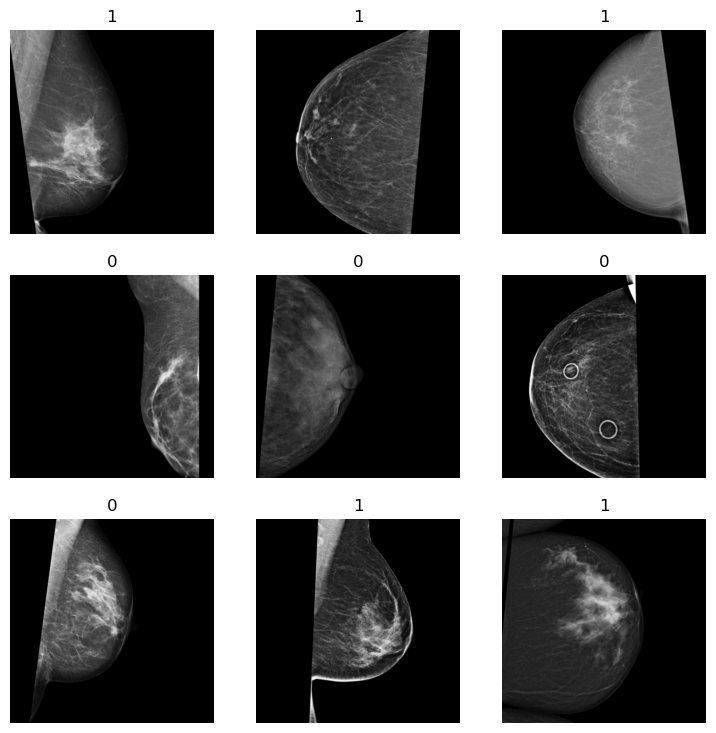

In [9]:
dls.show_batch()

Amb class_weight definirem una llista que conté els pesos assignats a cada classe, com en aquest cas tenim més imatges Normals que de Càncer, li assignarem un valor de 1, mentre que assignem 3 a Càncer. 
Creem el Learner utilitzant la funció vision_learner on li passarem el DataLoader, l’arquitectura preentrenada alexnet, una mètrica d’avaluacio del model, en aquest cas la precisió i la funció de pèrdua, loss function, on utilitzarem la Cross Entropy Loss passant-li els pesos definits anteriorment.

La funció de pèrdua el que fa és quantificar l’error entre les prediccions i les etiquetes, i ajusten els paràmetres del model durant l’entrenament de manera que la pèrdua es minimitzi. 

In [10]:
class_weights = [1.0, 3.0]
learn = vision_learner(dls, alexnet, metrics=accuracy, loss_func=CrossEntropyLossFlat(weight=torch.FloatTensor(class_weights)))
#lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 242MB/s]


Entrenem el model, especificant el nombre d'epochs i el learning rate

In [11]:
learn.fine_tune(25, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.317386,0.905887,0.525090,01:59


epoch,train_loss,valid_loss,accuracy,time
0,1.122082,0.874641,0.458781,01:50
1,1.044542,0.858524,0.458781,01:52
2,0.974410,0.830197,0.516129,01:50
3,0.963186,0.762589,0.582437,01:50
4,0.929859,0.811857,0.607527,01:50
5,0.896224,0.833075,0.616487,01:51
6,0.841477,0.786394,0.582437,01:50
7,0.824688,0.752426,0.564516,01:51
8,0.794546,0.730203,0.559140,01:50
9,0.723790,0.723058,0.559140,01:50


Mostrem la matriu de confusió resultant. Aquesta matriu mostrarà com classifica les dades de validació.

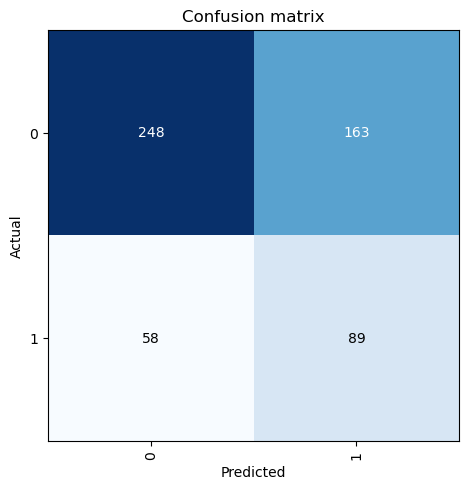

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Mostrem visualment la classificació que realitza el nostre model

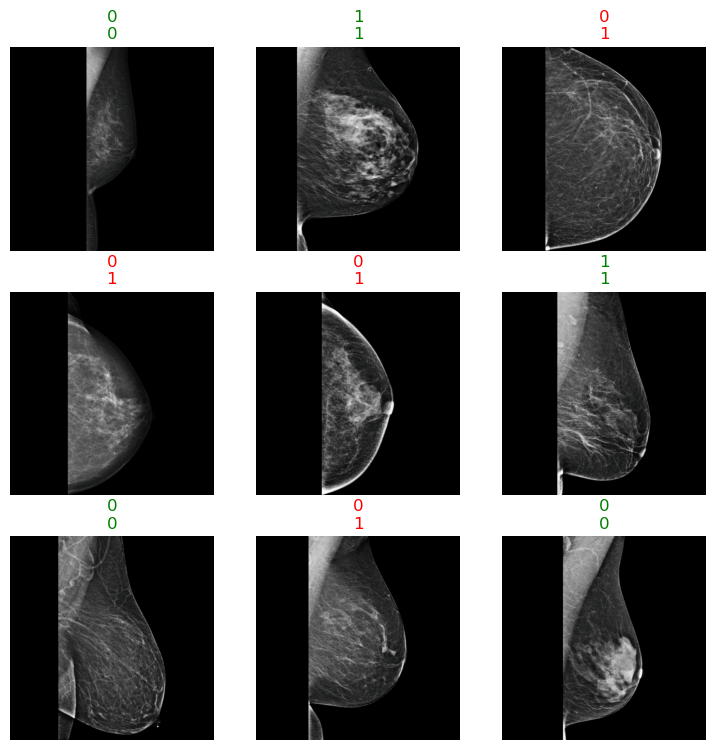

In [13]:
learn.show_results()

Exportem el model per a poder utilitzar-lo més endavant

In [14]:
learn.export('model.pkl')